In [16]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
from PIL import Image
import os
from torch.utils.data import DataLoader, Dataset

%cd C:/Users/elmer/Downloads/DataTraining2

C:\Users\elmer\Downloads\DataTraining2


In [17]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import numpy as np
from PIL import Image

# Parámetros de configuración
num_epocas = 20
batch_size_train = 32
batch_size_test = 64
learning_rate = 0.01
num_classes = 5  # Actualiza esto según tu número de clases

# Clase del dataset personalizado para clasificación
class CustomClassificationDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = np.genfromtxt(csv_file, delimiter=',', skip_header=1, dtype=None, encoding=None)
        self.root_dir = root_dir
        self.transform = transform
        self.label_mapping = {
            0: 0,
            400: 1,
            500: 2,
            600: 3,
            1000: 4
        }

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data[idx][0])
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)
        
        original_label = int(self.data[idx][2])
        # Aplicar mapeo de etiquetas
        label = self.label_mapping[original_label]
        
        return image, label


# Definir transformaciones de preprocesamiento de imagen
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((120, 90)),
    transforms.ToTensor(),
    transforms.Normalize([0.485], [0.229])
])

# Crear el dataset personalizado
data_dir = 'data_selection/data_clasificacion'
csv_file = 'data_selection/clasificacion.csv'
data = CustomClassificationDataset(csv_file=csv_file, root_dir=data_dir, transform=transform)

# Dividir los datos en entrenamiento y validación
train_size = int(0.8 * len(data))
val_size = len(data) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(data, [train_size, val_size])

# Crear DataLoaders
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size_train, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size_test, shuffle=False)

# Definir el modelo de red neuronal para clasificación
class ConvNet(nn.Module):
    def __init__(self, num_classes):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.conv5 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        
        # Simulación de un paso adelante para determinar el tamaño de salida automáticamente
        self._to_linear = None
        self.convs = nn.Sequential(
            self.conv1,
            nn.MaxPool2d(2),
            self.conv2,
            nn.MaxPool2d(2),
            self.conv3,
            nn.MaxPool2d(2),
            self.conv4,
            nn.MaxPool2d(2),
            self.conv5
        )
        self._get_conv_output_size(torch.rand(1, 1, 180, 180))
        
        self.fc1 = nn.Linear(self._to_linear, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def _get_conv_output_size(self, shape):
        with torch.no_grad():
            self._to_linear = np.prod(self.convs(shape).size()[1:])

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)  # Ajuste dinámico según el tamaño
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# Instanciación del modelo, optimizador y función de pérdida
model = ConvNet(num_classes=num_classes)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Función de evaluación en el conjunto de validación
def evaluate_model(val_loader, model, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return val_loss, accuracy

# Entrenamiento del modelo con early stopping y guardado del mejor modelo
def train_model_with_early_stopping(train_loader, val_loader, model, criterion, optimizer, num_epochs=20, patience=5):
    best_accuracy = 0.0
    current_patience = patience
    best_model_path = 'best_model_1.pth'

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)

        val_loss, val_accuracy = evaluate_model(val_loader, model, criterion)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

        # Check early stopping condition
        if val_accuracy > best_accuracy:
            torch.save(model.state_dict(), best_model_path)
            best_accuracy = val_accuracy
            current_patience = patience
        else:
            current_patience -= 1
            if current_patience == 0:
                print("Early stopping: No improvement in validation accuracy for {} epochs.".format(patience))
                break

# Llamada a la función de entrenamiento con early stopping
train_model_with_early_stopping(train_loader, val_loader, model, criterion, optimizer, num_epochs=num_epocas)


Epoch [1/20], Train Loss: 0.6094, Val Loss: 6.3919, Val Accuracy: 0.8729
Epoch [2/20], Train Loss: 0.4054, Val Loss: 6.5383, Val Accuracy: 0.8679
Epoch [3/20], Train Loss: 0.3971, Val Loss: 6.2161, Val Accuracy: 0.8654
Epoch [4/20], Train Loss: 0.3784, Val Loss: 6.1015, Val Accuracy: 0.8679
Epoch [5/20], Train Loss: 0.3759, Val Loss: 6.6533, Val Accuracy: 0.8687
Epoch [6/20], Train Loss: 0.3889, Val Loss: 7.6270, Val Accuracy: 0.8721
Early stopping: No improvement in validation accuracy for 5 epochs.


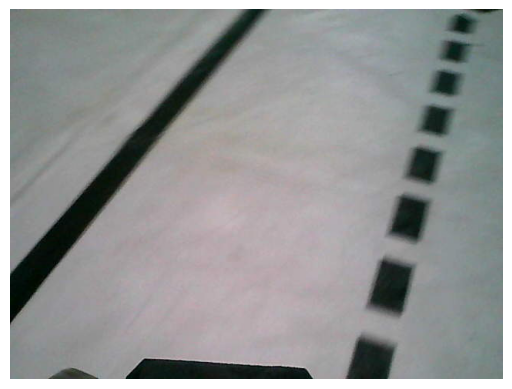

El índice de la clase predicha es: 3
0.026676654815673828


In [18]:
from PIL import Image
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import time

class ConvNet(nn.Module):
    def __init__(self, num_classes):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.conv5 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        
        # Simulación de un paso adelante para determinar el tamaño de salida automáticamente
        self._to_linear = None
        self.convs = nn.Sequential(
            self.conv1,
            nn.MaxPool2d(2),
            self.conv2,
            nn.MaxPool2d(2),
            self.conv3,
            nn.MaxPool2d(2),
            self.conv4,
            nn.MaxPool2d(2),
            self.conv5
        )
        self._get_conv_output_size(torch.rand(1, 1, 180, 180))
        
        self.fc1 = nn.Linear(self._to_linear, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def _get_conv_output_size(self, shape):
        with torch.no_grad():
            self._to_linear = int(torch.prod(torch.tensor(self.convs(shape).size()[1:])))

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)  # Ajuste dinámico según el tamaño
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def cargar_modelo_desde_ruta(ruta_modelo, num_classes):
    # Instanciar el modelo
    modelo = ConvNet(num_classes=num_classes)
    # Cargar los parámetros guardados del modelo
    modelo.load_state_dict(torch.load(ruta_modelo))
    # Asegurarse de que el modelo esté en modo de evaluación
    modelo.eval()
    return modelo

def realizar_prediccion_simplificada(ruta_modelo, imagen):
    # Cargar el modelo desde la ruta especificada
    modelo = cargar_modelo_desde_ruta(ruta_modelo, num_classes=5)  # Ajusta num_classes según tu modelo
    transformaciones = transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((120, 90)),
        transforms.ToTensor(),
        transforms.Normalize([0.485], [0.229])
    ])
    imagen_transformada = transformaciones(imagen).unsqueeze(0)  # Añade una dimensión de lote al principio
    modelo.eval()
    with torch.no_grad():
        salida = modelo(imagen_transformada)
    _, prediccion = torch.max(salida, 1)  # Obtiene el índice de la máxima puntuación
    return prediccion.item()  # Devuelve el índice de la clase predicha

# Ruta del modelo
ruta_modelo = 'best_model.pth'  # Ajusta la ruta según sea necesario

# Ruta de la imagen
imagen_path = 'C:/Users/elmer/Downloads/DataTraining2/TESTEO/1.jpg'  # Asegúrate de ajustar la ruta según sea necesario
imagen = Image.open(imagen_path)

# Mostrar la imagen
plt.imshow(imagen)
plt.axis('off')
plt.show()
# Realiza la predicción
start_time = time.time()
etiqueta_predicha = realizar_prediccion_simplificada(ruta_modelo, imagen)
end_time = time.time()
prediction_time = end_time - start_time

print(f'El índice de la clase predicha es: {etiqueta_predicha}')
print(prediction_time)